# MUSE-to-H&E CycleGAN training

In [1]:
import wandb
from fastai.vision.all import *
from fastai.callback.wandb import *
from fastai.basics import *
from upit.models.cyclegan import *
from upit.train.cyclegan import *
from upit.data.unpaired import *
from upit.metrics import *

In [2]:
wandb.login()

wandb: Currently logged in as: tmabraham (use `wandb login --relogin` to force relogin)


True

In [3]:
data_path = Path('/mnt/wamri/WAMRI-LevensonLab/datasets/').expanduser()
muse2he_path = data_path/'muse2he_urothelial_carcinoma'
muse2he_path.ls()

muse_path = muse2he_path/'trainA_2'
he_path = muse2he_path/'trainB'

torch.cuda.set_device(0) #set GPU id

In [4]:
dls = get_dls(muse_path, he_path, load_size=512, crop_size=256)

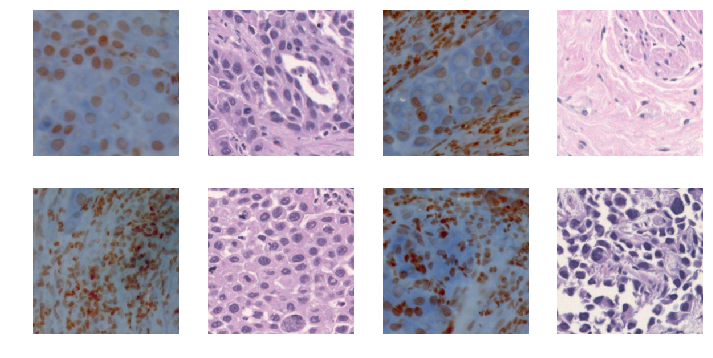

In [5]:
dls.show_batch()

In [6]:
wandb.init(project='upit-example')

wandb: wandb version 0.10.18 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [7]:
cycle_gan = CycleGAN(3,3,64, gen_blocks=9)
learn = cycle_learner(dls, 
                      cycle_gan,
                      opt_func=partial(Adam,mom=0.5,sqr_mom=0.999),
                      metrics=[FrechetInceptionDistance()],
                      cbs=[WandbCallback(log_dataset=True, log_model=True)]).to_fp16()

/home/tmabraham/fastai/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (G_A) that exists in the learner. Use `self.learn.G_A` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
/home/tmabraham/fastai/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (G_B) that exists in the learner. Use `self.learn.G_B` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
/home/tmabraham/fastai/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (D_A) that exists in the learner. Use `self.learn.D_A` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
/home/tmabraham/fastai/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (D_B) that exists in the learner. Use `self.learn.D_B` to avoi

SuggestedLRs(lr_min=8.317637839354575e-05, lr_steep=7.585775892948732e-05)

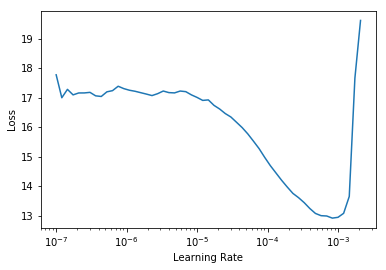

In [8]:
#cuda
learn.lr_find()

WandbCallback could not retrieve the dataset path, please provide it explicitly to "log_dataset"
WandbCallback requires use of "SaveModelCallback" to log best model
WandbCallback was not able to prepare a DataLoader for logging prediction samples -> list index out of range


epoch,train_loss,id_loss_A,id_loss_B,gen_loss_A,gen_loss_B,cyc_loss_A,cyc_loss_B,D_A_loss,D_B_loss,frechet_inception_distance,time
0,8.075416,1.004937,1.500230,0.554505,0.704840,2.057968,2.890186,0.370471,0.370471,76.281706,00:39
1,6.221604,0.686130,0.913674,0.297799,0.323259,1.410925,1.698521,0.278537,0.278537,76.377576,00:39
2,5.308773,0.632288,0.723532,0.294449,0.306837,1.310979,1.368787,0.270106,0.270106,76.484070,00:39
3,5.063966,0.638056,0.780320,0.299290,0.311133,1.307548,1.524226,0.257332,0.257332,76.191205,00:39
4,4.817234,0.588265,0.744597,0.302919,0.310341,1.217960,1.461689,0.253327,0.253327,77.068727,00:39
5,4.519131,0.596247,0.613867,0.300099,0.306616,1.226552,1.207581,0.252807,0.252807,76.687654,00:38
6,4.320335,0.577573,0.587779,0.293928,0.312001,1.167829,1.188718,0.248298,0.248298,77.677220,00:38
7,4.220501,0.583570,0.565542,0.293466,0.314734,1.175417,1.169157,0.247252,0.247252,76.954147,00:38
8,4.097529,0.560442,0.526878,0.308453,0.315599,1.142392,1.079320,0.244568,0.244568,76.669751,00:38
9,4.070811,0.557719,0.574041,0.297665,0.338411,1.123147,1.192311,0.237941,0.237941,76.645063,00:39


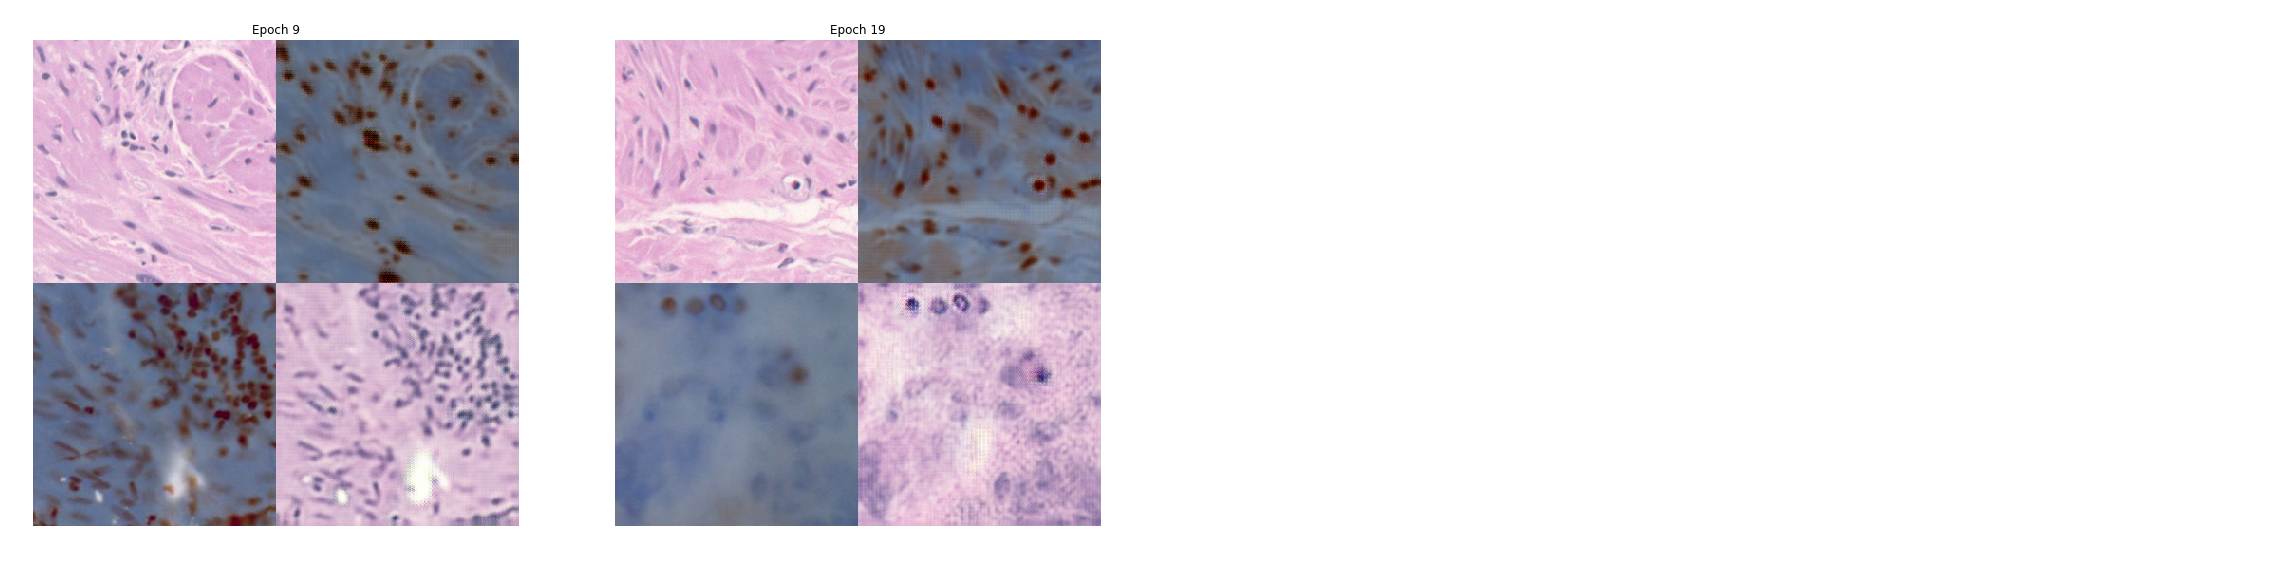

In [9]:
#cuda
learn.fit_flat_lin(10,10,2e-4)

In [10]:
learn.save('muse2he-200epoch')

Path('models/muse2he-200epoch.pth')

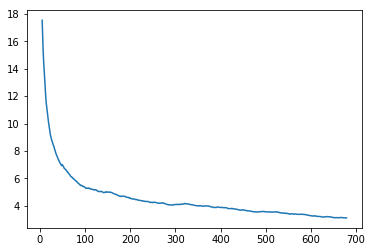

In [11]:
learn.recorder.plot_loss(with_valid=False)

In [12]:
b = dls.train.one_batch()
_,_,preds = learn.get_preds(dl=[b], with_decoded=True)

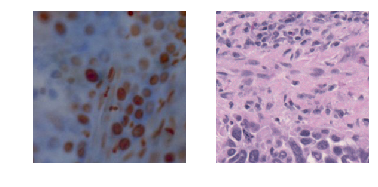

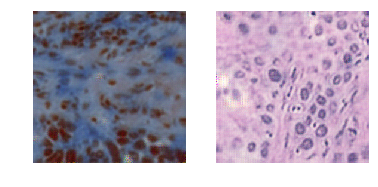

In [13]:
dls.show_batch((b[0], b[1]), max_n=1, show=True)
dls.show_batch((preds[0],preds[1]), max_n=1, show=True)

In [14]:
wandb.finish()

epoch,20
train_loss,3.12814
raw_loss,3.33377
wd_0,0.01
sqr_mom_0,0.999
lr_0,0.0
mom_0,0.5
eps_0,1e-05
_step,679
_runtime,842
_timestamp,1612917648


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_loss,█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
raw_loss,█▄▃▅▅▂▅▂▅▃▂▃▂▂▃▃▂▃▃▂▃▂▁▂▁▂▂▁▂▂▂▁▁▂▂▂▁▁▂▂
wd_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,█████████████████████▇▇▇▆▆▆▅▅▅▄▄▄▃▃▂▂▂▁▁
mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
